<a href="https://colab.research.google.com/github/alexunderch/Bachelor_materials/blob/main/assignment1_01_Word_Vectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 01. Simple text processing.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython import display

from collections import OrderedDict
from sklearn.base import TransformerMixin
from typing import List, Union
import numpy as np
import heapq

### Toxic or not
Your main goal in this assignment is to classify, whether the comments are toxic or not. And practice with both classical approaches and PyTorch in the process.

*Credits: This homework is inspired by YSDA NLP_course.*

In [ ]:
# In colab run this cell
! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_f20/homeworks_advanced/assignment1_01_Word_Vectors/utils.py -nc
# ! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_f20/homeworks_advanced/assignment1_01_Word_Vectors/features.py -nc

--2021-02-07 08:55:34--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_f20/homeworks_advanced/assignment1_01_Word_Vectors/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     579  --.-KB/s    in 0s      

2021-02-07 08:55:34 (36.3 MB/s) - ‘utils.py’ saved [579/579]



In [ ]:
try:
    data = pd.read_csv('../../datasets/comments_small_dataset/comments.tsv', sep='\t')
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_f20/datasets/comments_small_dataset/comments.tsv -nc
    data = pd.read_csv("comments.tsv", sep='\t')

--2021-02-07 08:55:35--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_f20/datasets/comments_small_dataset/comments.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353358 (345K) [text/plain]
Saving to: ‘comments.tsv’

comments.tsv        100%[===================>] 345.08K  --.-KB/s    in 0.04s   

2021-02-07 08:55:35 (8.21 MB/s) - ‘comments.tsv’ saved [353358/353358]



In [ ]:
texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [ ]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size = .5, random_state = 42)

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [ ]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [ ]:
# task: preprocess each comment in train and test
def tokenize_tweets(tweets):
    tokenizer = TweetTokenizer()
    preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))
    return [preprocess(tweet) for tweet in tweets]

texts_train = tokenize_tweets(texts_train)#<YOUR CODE>
texts_test = tokenize_tweets(texts_test)#<YOUR CODE>

In [ ]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Step 1: bag of words

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [ ]:
class BoW(TransformerMixin):
    """
    Bag of words tranformer class
    
    check out:
    https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html
    to know about TransformerMixin class
    """

    def __init__(self, k: int):
        """
        :param k: number of most frequent tokens to use
        """
        self.k = k
        # list of k most frequent tokens
        self.bow = None

    def fit(self, corpus: np.ndarray, y = None):
        """
        :param X: array of texts to be trained on
        """
        # task: find up to self.k most frequent tokens in texts_train,
        # sort them by number of occurences (highest first)
        # store most frequent tokens in self.bow


        self.bow = dict()
        for index in range(len(corpus)):
            tokens = list(corpus[index].split())
            for token in tokens:
                if token not in self.bow.keys(): self.bow[token] = 1
                else: self.bow[token] += 1

        # print(list(dict(sorted(self.bow.items(), key = lambda item: -item[1])[:self.k]).keys()) == heapq.nlargest(self.k, self.bow, key = self.bow.get))
        self.bow = list(dict(sorted(self.bow.items(),
                                    key = lambda item: -item[1])[:self.k]).keys())

        # raise NotImplementedError
        # fit method must always return self
        return self

    def _text_to_bow(self, text: str) -> np.ndarray:
        """
        convert text string to an array of token counts. Use self.bow.
        :param text: text to be transformed
        :return bow_feature: feature vector, made by bag of words
        """
        result = np.zeros(len(self.bow))
        tokens = text.split()
        for ind, token in enumerate(self.bow):
            if token in tokens: result[ind] += tokens.count(token)
        # raise NotImplementedError
        return np.array(result, "float32")

    def transform(self, corpus: np.ndarray, y = None) -> np.ndarray:
        """
        :param X: array of texts to transform
        :return: array of transformed texts
        """
        assert self.bow is not None
        return np.stack([self._text_to_bow(corpus[index]) for index in range(len(corpus))])

    def get_vocabulary(self) -> Union[List[str], None]:
        return self.bow

In [ ]:
# from features import BoW

# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(' '.join(texts_train).split())))

#<YOUR CODE>
bow = BoW(k)
bow.fit(texts_train)

print('example features:', sorted(bow.get_vocabulary())[::100])

example features: ['!', '12:20', '300', '_', 'adorned', 'alternative', 'archive', 'average', 'benkner', 'bout', 'came', 'chest', 'combined', 'consumers', 'cricket', 'decisions', 'dickheads', 'domestic', 'eductaion', 'essentially', 'faggot', 'firms', 'frustrated', 'goal', 'hanibal', 'hip-hop', 'identified', 'infoboxes', 'issue', 'kindergarten', 'lets', 'lot', "mclaren's", 'moderator', 'naturally', 'noticeable', 'opposing', 'pdf', 'plant', 'pretoria', 'punctuation', 'rebels', 'repetative', 'riadh', 'schulz', 'shes', 'slit', 'spoof', 'stupid', 't', 'theoretical', 'topic', 'uglyness', 'userspace', 'wanted', 'wikieditor', 'year', 'ீ']


In [ ]:
X_train_bow = bow.transform(texts_train)
X_test_bow = bow.transform(texts_test)


In [ ]:
# Small check that everything is done properly
bow_vocabulary = bow.get_vocabulary()
k_max = len(set(' '.join(texts_train).split()))

assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Now let's do the trick with `sklearn` logistic regression implementation:

In [ ]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

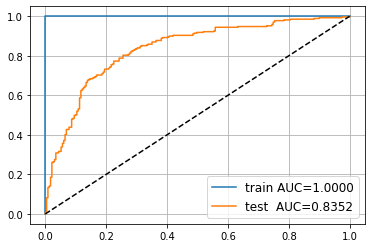

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
def get_roc_auc(model, X_train, y_train, X_test, y_test, use_torch = False):
    for name, X, y, model in [
        ('train', X_train, y_train, model),
        ('test ', X_test, y_test, model)
    ]:
        if use_torch: proba = model(X).detach().cpu().numpy()[:, 1]
        else: proba = model.predict_proba(X)[:, 1]
        auc = roc_auc_score(y, proba)
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.grid()
    return 0
_ = get_roc_auc(bow_model, X_train_bow, y_train, X_test_bow, y_test)

Seems alright. Now let's create the simple logistic regression using PyTorch. Just like in the classwork.

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.metrics import accuracy_score

In [ ]:
from utils import plot_train_process

In [ ]:
model = nn.Sequential()

model.add_module('l1', nn.Linear(bow.k, 2)) ### YOUR CODE HERE
### YOUR CODE HERE
print(bow.k)

5722


Remember what we discussed about loss functions! `nn.CrossEntropyLoss` combines both log-softmax and `NLLLoss`.

__Be careful with it! Criterion `nn.CrossEntropyLoss` with still work with log-softmax output, but it won't allow you to converge to the optimum.__ Next comes small demonstration:

In [ ]:
# loss_function = nn.NLLLoss()
loss_function = nn.CrossEntropyLoss()

In [ ]:
opt = torch.optim.Adam(model.parameters()) ### YOUR CODE HERE1

In [ ]:
X_train_bow_torch = torch.FloatTensor(X_train_bow) ### YOUR CODE HERE
X_test_bow_torch = torch.FloatTensor(X_test_bow)### YOUR CODE HERE

y_train_torch = torch.tensor(y_train) ### YOUR CODE HERE
y_test_torch = torch.tensor(y_test)### YOUR CODE HERE

Let's test that everything is fine

In [ ]:
# example loss
loss = loss_function(model(X_train_bow_torch[:3]), y_train_torch[:3])

In [ ]:
assert type(loss.item()) == float

Here comes small function to train the model. In future we will take in into separate file, but for this homework it's ok to implement it here. 

In [ ]:
def train_model(
    model,
    opt,
    lr_scheduler,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations = 500,
    batch_size = 32,
    warm_start = False,
    show_plots = True,
    eval_every = 10):
    if not warm_start:
        for name, module in model.named_children():
            print('resetting ', name)
            try:
                module.reset_parameters()
            except AttributeError as e:
                print('Cannot reset {} module parameters: {}'.format(name, e))

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # sample 256 random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch) ### YOUR CODE

        # compute loss, just like before
        ### YOUR CODE
        loss = loss_function(y_predicted, y_batch)

        # compute gradients
        ### YOUR CODE
        loss.backward()
        # Adam step
        ### YOUR CODE
        opt.step()
        # clear gradients
        ### YOUR CODE
        opt.zero_grad()


        local_train_loss_history.append(loss.data.numpy())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis = 1))
            val_acc_history.append(acc_score_val)
            lr_scheduler.step(train_loss_history[-1])

            if show_plots:
                display.clear_output(wait = True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

Let's run it on the data. Note, that here we use the `test` part of the data for validation. It's not so good idea in general, but in this task our main goal is practice.

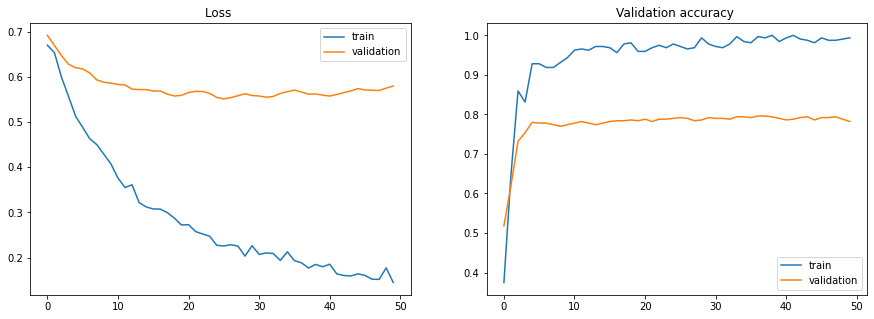

Sequential(
  (l1): Linear(in_features=5722, out_features=2, bias=True)
)

In [ ]:
train_model(model, opt, ReduceLROnPlateau(opt), X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch)

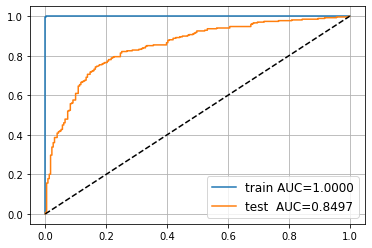

In [ ]:
_ = get_roc_auc(model, X_train_bow_torch, y_train, X_test_bow_torch, y_test, True)

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

Using k == 100 most frequent tokens
resetting  l1


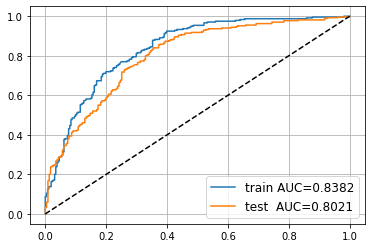

Using k == 572 most frequent tokens
resetting  l1


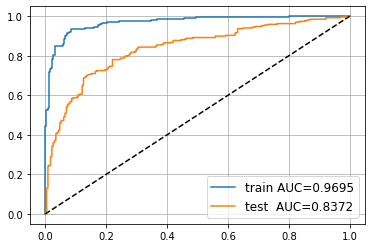

Using k == 2861 most frequent tokens
resetting  l1


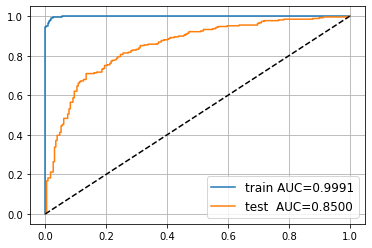

Using k == 5722 most frequent tokens
resetting  l1


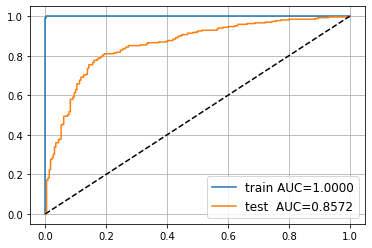

In [ ]:
# Your beautiful code here
ks = [100, k_max // 10, k_max // 2, k_max]

for k in ks:
    print("Using k == {} most frequent tokens".format(k))
    bow = BoW(k)
    bow.fit(texts_train)
    X_train_bow = bow.transform(texts_train)
    X_test_bow = bow.transform(texts_test)  
    X_train_bow_torch = torch.FloatTensor(X_train_bow) 
    X_test_bow_torch = torch.FloatTensor(X_test_bow)

    y_train_torch = torch.tensor(y_train)
    y_test_torch = torch.tensor(y_test)
    model = nn.Sequential(); model.add_module('l1', nn.Linear(bow.k, 2)) 
    opt = torch.optim.Adam(model.parameters())
    _ = train_model(model, opt, ReduceLROnPlateau(opt), X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch, show_plots = False)
    plt.show()
    _ = get_roc_auc(model, X_train_bow_torch, y_train, X_test_bow_torch, y_test, True)
    plt.show()

    

### Step 2: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [ ]:
# from features import TfIdf
class TfIdf(TransformerMixin):
    """
    Tf-Idf tranformer class
    if you have troubles implementing Tf-Idf, check out:
    https://streamsql.io/blog/tf-idf-from-scratch
    """

    def __init__(self, k: int = None, normalize: bool = False):
        """
        :param k: number of most frequent tokens to use
        if set k equals None, than all words in train must be considered
        :param normalize: if True, you must normalize each data sample
        after computing tf-idf features
        """
        self.k = k
        self.normalize = normalize

        # self.idf[term] = log(total # of documents / # of documents with term in it)
        self.tf_idf = None

    def fit(self, corpus: np.ndarray, y = None):
        """
        :param corpus: array of texts to be trained on
        """
        # raise NotImplementedError
        all_tokens = set(' '.join(corpus).split())
        if self.k is None: self.k = len(all_tokens)

        self.wordfreq = dict()
        for document in corpus:
            for term in document.split():
                if term not in self.wordfreq.keys(): self.wordfreq[term] = 1
                else: self.wordfreq[term] += 1

        self.wordfreq = list(dict(sorted(self.wordfreq.items(),
                                    key = lambda item: -item[1])[:self.k]).keys())
        

        self.idf = dict()
        for term in self.wordfreq:
            doc_containing_word = 0
            for document in corpus:
                if term in document.split(): doc_containing_word += 1
            self.idf[term] = np.log(len(corpus)/(1 + doc_containing_word))

        # self.tf = dict()
        # for term in self.wordfreq:
        #     tf_vector = []
        #     for document in corpus:
        #         doc_freq = 0
        #         for word in document.split():
        #            if term == word: doc_freq += 1
        #         if self.normalize: doc_freq /= len(document.split())
        #         tf_vector.append(doc_freq)
        #     self.tf[term] = tf_vector

        # self.tfidf = []
        # for term in self.tf.keys():
        #     tfidf_per_document = []
        #     for doc_tf in self.tf[term]:
        #         tfidf_per_document.append(doc_tf * self.idf[term])
        #     self.tfidf.append(tfidf_per_document)

        # fit method must always return self
        return self

    def _text_to_tf_idf(self, text: str) -> np.ndarray:
        """
        convert text string to an array tf-idfs.
        *Note* don't forget to normalize, when self.normalize == True
        :param text: text to be transformed
        :return tf_idf: tf-idf features
        """
        result = []
        tmp_text = text.split()
        for term in self.wordfreq:
            if term in tmp_text:
                n = tmp_text.count(term)
                if self.normalize: n /= len(tmp_text)
                result.append(n * self.idf[term])
            else: result.append(.0)
        
        # raise NotImplementedError
        return np.array(result, "float64")

    def transform(self, X: np.ndarray, y = None) -> np.ndarray:
        """
        :param X: array of texts to transform
        :return: array of transformed texts
        """
        assert self.idf is not None
        return np.stack([self._text_to_tf_idf(text) for text in X])

Same stuff about moel and optimizers here (or just omit it, if you are using the same model as before).

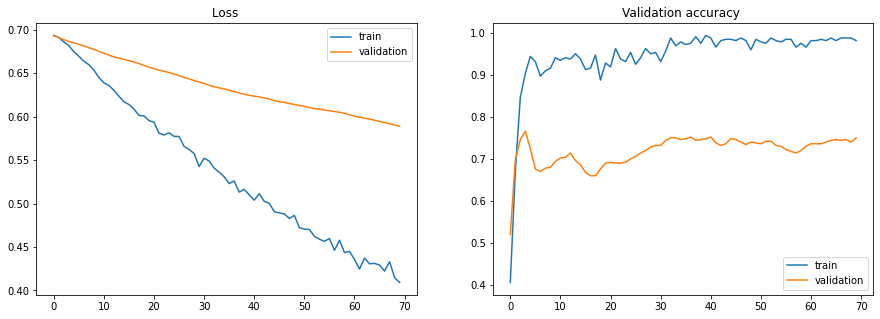

Sequential(
  (l1): Linear(in_features=5722, out_features=2, bias=True)
)

In [ ]:
### YOUR CODE HERE
tfifdf = TfIdf(None, True)
tfifdf.fit(texts_train)

X_train_tfidf = tfifdf.transform(texts_train)
X_test_tfidf = tfifdf.transform(texts_test)


X_train_tfidf_torch = torch.FloatTensor(X_train_tfidf) ### YOUR CODE HERE
X_test_tfidf_torch = torch.FloatTensor(X_test_tfidf)### YOUR CODE HERE

y_train_torch = torch.tensor(y_train) ### YOUR CODE HERE
y_test_torch = torch.tensor(y_test)### YOUR CODE HEREX

model2 = nn.Sequential()

model2.add_module('l1', nn.Linear(tfifdf.k, 2))
opt = torch.optim.Adam(model2.parameters()) ### YOUR CODE HERE1

train_model(model2, opt, ReduceLROnPlateau(opt), X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch, n_iterations = 700)

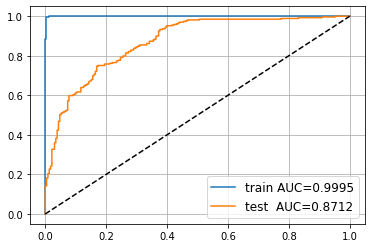

In [ ]:
_ = get_roc_auc(model2, X_train_tfidf_torch, y_train, X_test_tfidf_torch, y_test, True)


Using k == 100 most frequent tokens
resetting  l1


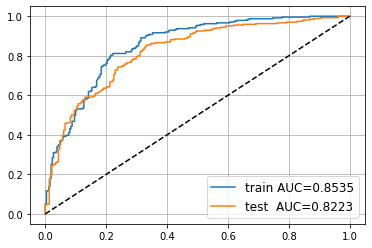

Using k == 572 most frequent tokens
resetting  l1


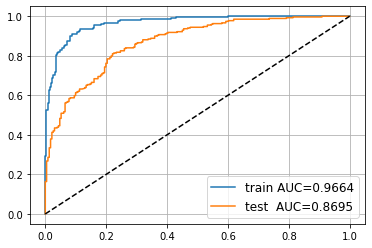

Using k == 2861 most frequent tokens
resetting  l1


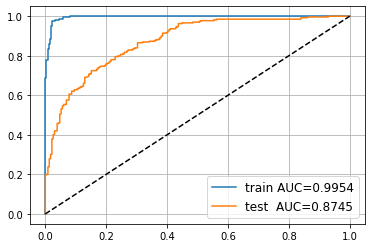

Using k == None most frequent tokens
resetting  l1


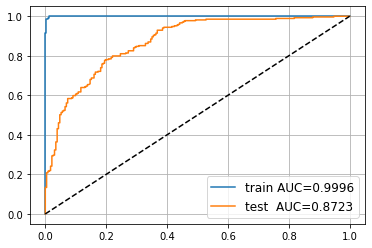

In [ ]:
ks = [100, k_max // 10, k_max // 2, None]

for k in ks:
    print("Using k == {} most frequent tokens".format(k))
    tfifdf = TfIdf(k, True)
    tfifdf.fit(texts_train)
    X_train_tfifdf = tfifdf.transform(texts_train)
    X_test_tfifdf = tfifdf.transform(texts_test)  
    X_train_tfifdf_torch = torch.FloatTensor(X_train_tfifdf) 
    X_test_tfifdf_torch = torch.FloatTensor(X_test_tfifdf)

    y_train_torch = torch.tensor(y_train)
    y_test_torch = torch.tensor(y_test)
    model = nn.Sequential(); model.add_module('l1', nn.Linear(tfifdf.k, 2)) 
    opt = torch.optim.Adam(model.parameters())
    _ = train_model(model, opt, ReduceLROnPlateau(opt), X_train_tfifdf_torch, y_train_torch, X_test_tfifdf_torch, y_test_torch, show_plots = False)
    plt.show()
    _ = get_roc_auc(model, X_train_tfifdf_torch, y_train, X_test_tfifdf_torch, y_test, True)
    plt.show()

Fit your model to the data. No not hesitate to vary number of iterations, learning rate and so on.

_Note: due to very small dataset, increasing the complexity of the network might not be the best idea._

### Step 3: Comparing it with Naive Bayes

Naive Bayes classifier is a good choice for such small problems. Try to tune it for both BOW and TF-iDF features. Compare the results with Logistic Regression.

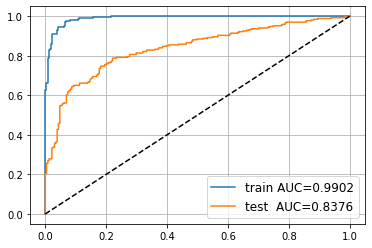

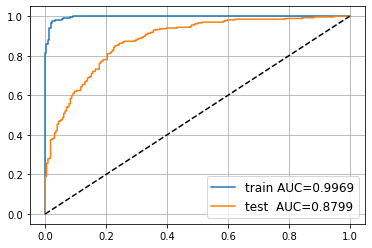

In [ ]:
# Your beautiful code here
from sklearn.naive_bayes import MultinomialNB
bow_model_ = MultinomialNB().fit(X_train_bow, y_train)
tfidf_model_ = MultinomialNB().fit(X_train_tfidf, y_train)

_ = get_roc_auc(bow_model_, X_train_bow, y_train, X_test_bow, y_test)
plt.show()
_ = get_roc_auc(tfidf_model_, X_train_tfidf, y_train, X_test_tfidf, y_test)


Shape some thoughts on the results you aquired. Which model has show the best performance? Did changing the learning rate/lr scheduler help?

_Your beautiful thoughts here_

### Step 4: Using the external knowledge.

Use the `gensim` word2vec pretrained model to translate words into vectors. Use several models with this new encoding technique. Compare the results, share your thoughts.

In [ ]:
# Your beautiful code here